##  프로야구팀 시즌승률 예측을 위한 선형회귀모델 구현결과

> KBO 홈페이지에서 01 ~ 18 시즌 팀기록을 웹크롤링하여 수집한 데이터를 기반으로 팀승률을 종속변수로하는 선형회귀모델 구현

### 1. 개요

#### 1.1. 아이디어

- 2019 시즌 응원하는 팀의 시즌 승률을 예측할 수 있는 방법이 있을까하는 아이디어에서 출발


- KBO 홈페이지에서 팀기록을 크롤링하여 선형회귀 분석모델을 구현해보자는 구상

#### 1.2.  프로젝트 목적

- KBO 홈페이지에서 2001 ~ 2018 시즌 팀기록을 웹크롤링하여 수집한 데이터를 기반으로 팀승률을 종속변수로하는 선형회귀모델 구현


#### 1.3. 기술스텍

- 파이썬 프로그래밍, 웹크롤링, 선형회귀분석, 데이터 전처리 등

### 2. 프로젝트 수행결과 요약

#### STEP 1) 문제정의 및 프로젝트 계획 구상

- 아이디어 도출


- 프로젝트 시행 계획 수립


#### STEP 2) 데이터 수집


- KBO 공식 홈페이지 'https://www.koreabaseball.com/TeamRank/TeamRank.aspx' 크롤러 파이썬 코드구현


- 데이터 수집결과

팀명, 승률, 팀 방어율, 팀 타율 등 데이터 수집


#### STEP 3) 데이터 탐색

- 결측치 확인


- 피쳐별 변수치우침 여부 확인


- 피쳐별 이상치 확인


- 피쳐 간 상관관계 확인

#### STEP 4) 데이터 전처리

1) error(팀실책), P_hitted(팀 피안타) 변수 등을 각각 num_game(시즌 총 경기수) 변수로 나누어서 각각 경기당 팀실책, 경기당 팀피안타 등으로 전처리

- 사유 : model prediction 시 편의성 도모


2) feature selection 기법적용

일부 변수 간 조합으로 가장 높은 퍼포먼스를 보여주는 변수추출


#### STEP 5) 모델링 및 모델평가

1) 실제 데이터와 모델 예측값 비교

2) 잔차정규성 검정

3) Kfold 교차검증


### 3. 프로젝트 수행결과 상세

#### STEP 2) 데이터 수집

1) 웹크롤러 구현 및 데이터 수집결과

- 웹크롤러는 KBO_crawler.py에 구현

In [1]:
## 필요한 모듈 임포트
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
import statsmodels.api as sm
from sklearn.feature_selection import *
from sklearn.model_selection import train_test_split
import pandas as pd
import itertools
from sklearn.metrics import * 
from sklearn.model_selection import KFold
from statsmodels.graphics import utils
from statsmodels.stats.outliers_influence import variance_inflation_factor

- 웹크롤러 실행결과

KBO 공식홈페이지 팀기록 파트 https://www.koreabaseball.com/TeamRank/TeamRank.aspx 크롤링 및 수집한 데이터 KBO_record.plk로 저장

In [12]:
! python KBO_crawler.py

Crawling start
Crawling complete, endtime :   362.8636794090271
reset indexing complete
KBO_record.plk save complete, program done!


In [2]:
# 저장한 데이터 로드
df = pd.read_pickle("KBO_record.plk")

<img src="1.png" width="1000" />

컬럼설명

- rank : 순위, num_game : 시즌 게임수, win_rate : 승률, AVG : 팀타율, scoring : 팀득점 , "hit" : h, 팀 1루타 수


- "double" : double, 팀 2루타 수, 'triple' : triple, 팀 3루타 수, 'HR' : 팀 홈런수, 'RBI' : 팀 타점, 'SAC' : 팀 희생번트수


- 'SF' : 팀 희생플라이수, "RISP" : 팀 득점권타율, "PA_BA" : 팀 대타타율, "ERA" : 팀 평균자책점, "save" : 팀 세이브 수


- 'hold' : 팀 홀드수,'PW' : 팀 선발투수 승률,'P_hitted' : 팀 피안타,'SO' : 팀 탈삼진,'WHIP' : 팀 WHIP


- "CG" : 팀 완투, "shutout" : 팀 완봉, 'QS' : 팀 퀄리티 스타트 수, 'BV' : 팀 블론세이브 수, 'PN' : 팀 투구수


- 'P_AVG' : 팀 피안타율, 'WP' : 팀 와일드피치, "error" : 팀 실책수

#### STEP 3) 데이터 탐색 및 전처리

1) error(팀실책), P_hitted(팀 피안타) 변수를 각각 num_game(시즌 총 경기수) 변수로 나누어서 각각 경기당 팀실책, 경기당 팀피안타로 전처리

- 사유 : model prediction 시 편의성 도모

In [3]:
df['num_game'] = df['num_game'].apply(lambda data: float(data))
# num_game 컬럼 float 형태의 데이터로 변경

for column in list(df.columns[2:]):
    df[column] = df[column].apply(lambda data: float(data))

for columns in ['error','P_hitted']:
    df[columns] = df[columns] / df['num_game']

2) 컬럼별 결측값 확인

In [4]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
error,0,0.0
BV,0,0.0
team,0,0.0
rank,0,0.0
win_rate,0,0.0
ERA,0,0.0
save,0,0.0
hold,0,0.0
PW,0,0.0
P_hitted,0,0.0


3) 피쳐별 변수치우침 여부 확인

In [5]:
## skew 절대값이 1.5인 컬럼 확인
abs(df[df.columns[4:]].skew()) > 1.5

ERA         False
save        False
hold        False
PW          False
P_hitted    False
SO          False
WHIP        False
CG          False
shutout     False
QS          False
BV          False
PN          False
P_AVG       False
WP          False
AVG         False
scoring     False
hit         False
double      False
triple      False
HR          False
RBI         False
SAC         False
SF          False
OPS         False
RISP        False
PA_BA       False
error       False
dtype: bool

4) 모델의 일반화를 위한 피쳐별 이상치 확인

- 모델의 일반화를 위해 IOR Rule을 기준으로 일반분포에서 크게 벗어나는 레코드 삭제


- IOR = 3사분위수 - 1사분위수


- IOR Rule : Q3 +1.5 * IQR 보다 크거나 Q1-1.5 * IQR 보다 작으면 이상치라고 판단

=> 총 22개의 이상치 레코드 제거

In [6]:
df_temp = pd.DataFrame(columns=df.columns)

for column in df.columns[4:]:           
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    condition1 = Q1 - 1.5*IQR < df[column]
    condition2 = Q3 + 1.5*IQR > df[column]
    total_condition = np.logical_and(condition1, condition2)
    
    df_temp = pd.concat([df_temp,df[total_condition==False]])
    
    # 이상치 데이터 제외
    df = df[total_condition]
    
# 이상치 데이터만 모아놓은 데이터 프레임
df_temp

,num_game,team,rank,win_rate,ERA,save,hold,PW,P_hitted,SO,...,double,triple,HR,RBI,SAC,SF,OPS,RISP,PA_BA,error
15,133.0,2002_롯데,8.0,0.265,4.72,13.0,19.0,0.265,9.541353,775.0,...,206.0,19.0,85.0,443.0,49.0,22.0,0.660,0.224,0.131,0.879699
113,128.0,2014_한화,9.0,0.389,6.35,26.0,30.0,0.389,11.335938,748.0,...,223.0,24.0,104.0,594.0,50.0,43.0,0.774,0.266,0.221,0.882812
4,133.0,2001_KIA,5.0,0.469,5.01,28.0,16.0,0.469,9.255639,743.0,...,221.0,17.0,142.0,637.0,51.0,43.0,0.781,0.272,0.225,0.804511
6,133.0,2001_SK,7.0,0.458,4.38,33.0,22.0,0.458,8.631579,908.0,...,215.0,11.0,113.0,555.0,122.0,26.0,0.728,0.255,0.274,0.721805
10,133.0,2002_KIA,3.0,0.605,3.92,38.0,30.0,0.605,8.909774,862.0,...,220.0,14.0,120.0,611.0,45.0,35.0,0.746,0.268,0.250,0.759398
18,133.0,2003_KIA,3.0,0.609,3.62,36.0,34.0,0.609,8.210526,820.0,...,219.0,16.0,129.0,626.0,94.0,37.0,0.765,0.284,0.226,0.526316
41,126.0,2006_한화,2.0,0.540,3.35,41.0,47.0,0.540,8.547619,760.0,...,191.0,3.0,110.0,481.0,68.0,30.0,0.711,0.240,0.195,0.666667
50,126.0,2007_한화,3.0,0.540,3.54,39.0,36.0,0.540,8.603175,741.0,...,165.0,13.0,104.0,502.0,87.0,28.0,0.718,0.271,0.216,0.603175
58,126.0,2008_롯데,3.0,0.548,3.64,27.0,38.0,0.548,9.000000,671.0,...,199.0,22.0,93.0,590.0,62.0,51.0,0.761,0.273,0.189,0.730159
90,133.0,2012_두산,3.0,0.523,3.58,38.0,47.0,0.523,7.917293,802.0,...,172.0,26.0,59.0,490.0,102.0,40.0,0.674,0.286,0.201,0.586466


5) 변수간 상관관계 확인

- 모든변수간에 조합해서 비교하는 것은 상당히 경우의 수가 많기 때문에 생략하고, target value에 대한 다른 변수들간 상관관계 확인

결론 : 선발투수 승률은 곧 승률과 같기 때문에 선발투수와 승률간의 상관관계가 거의 일치함. 따라서 PW(선발투수 승률) 칼럼은 제거

In [7]:
## target value에 대한 변수간 상관관계 확인
temp = df[list(df.columns)[3:]].corr()
temp['win_rate'].sort_values(ascending=[False])

win_rate    1.000000
PW          0.998553
save        0.615544
OPS         0.476335
scoring     0.401554
RBI         0.393169
AVG         0.386213
shutout     0.380451
RISP        0.364409
QS          0.295634
HR          0.289986
hold        0.260972
SO          0.210495
hit         0.198183
SF          0.195622
triple      0.147323
double      0.144657
PA_BA       0.039216
SAC         0.002161
BV         -0.092802
CG         -0.095758
PN         -0.119596
error      -0.191001
WP         -0.287580
P_hitted   -0.425930
P_AVG      -0.506351
WHIP       -0.552409
ERA        -0.552462
Name: win_rate, dtype: float64

6) 아웃라이어 데이터 식별 및 제거

레버리지와 잔차의 크기가 모두 큰 데이터들을 아웃라이어로 판단하고자 하는데 통상 잔차와 레버리지를 동시에 보기위한 기준으로는 Cook's Distance가 있다. 결론적으로 Cook's Distance 지표를 이용하여 Fox' Outlier Recommendation를 적용하여 아래 수식을 충족하는 데이터를 아웃라이어로 판단

$$ D_i > \dfrac{4}{N − K - 1} $$

In [8]:
dfX = df[['ERA', 'save', 'hold', 'P_hitted', 'SO', 'WHIP', 'CG', 'shutout',
           'QS', 'BV', 'PN', 'P_AVG', 'WP', 'AVG', 'scoring', 'hit', 'double',
           'triple', 'HR', 'RBI', 'SAC', 'SF', 'OPS', 'RISP', 'PA_BA', 'error']]
dfX = sm.add_constant(dfX)
dfy = df[["win_rate"]]

model = sm.OLS(dfy, dfX)
result = model.fit()
pred = result.predict(dfX)

influence = result.get_influence()
cooks_d2, pvals = influence.cooks_distance
K = influence.k_vars
fox_cr = 4 / (len(dfy) - K - 1)
idx = np.where(cooks_d2 > fox_cr)[0]

print("아웃라이어 인덱스 번호 : " , idx)

## 아웃라이어 제거
df = df.drop(idx)
dfX = df[['ERA', 'save', 'hold', 'P_hitted', 'SO', 'WHIP', 'CG', 'shutout',
           'QS', 'BV', 'PN', 'P_AVG', 'WP', 'AVG', 'scoring', 'hit', 'double',
           'triple', 'HR', 'RBI', 'SAC', 'SF', 'OPS', 'RISP', 'PA_BA', 'error']]
dfX = sm.add_constant(dfX)
dfy = df[["win_rate"]]

len(dfX)

아웃라이어 인덱스 번호 :  [  5  37  66  73 108 110 117]


125

7) feature selection 기법적용

일부 변수 간 조합으로 가장 높은 퍼포먼스를 보여주는 변수추출

- 모든변수를 모델에 반영했을때 퍼포먼스 확인

=> 과적합 및 다중공선성 증상 확인, 확률론적 선형회귀모델을 준수하지 않는 현상(잔차정규성 통과미달) 확인

train R2 = 0.99996084, test R2 = 0.99517618


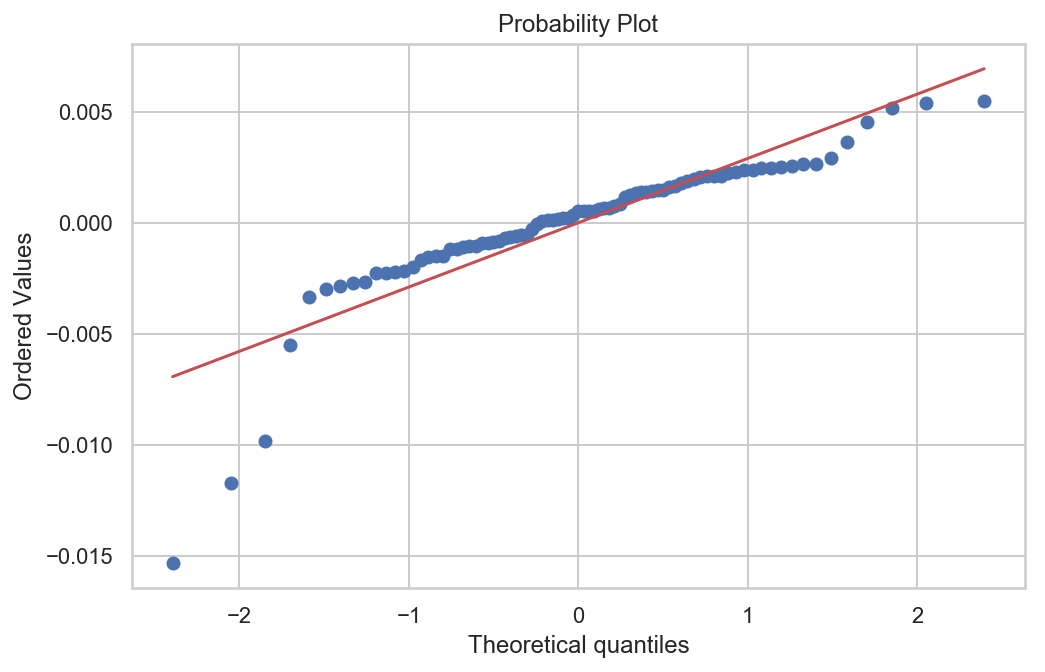

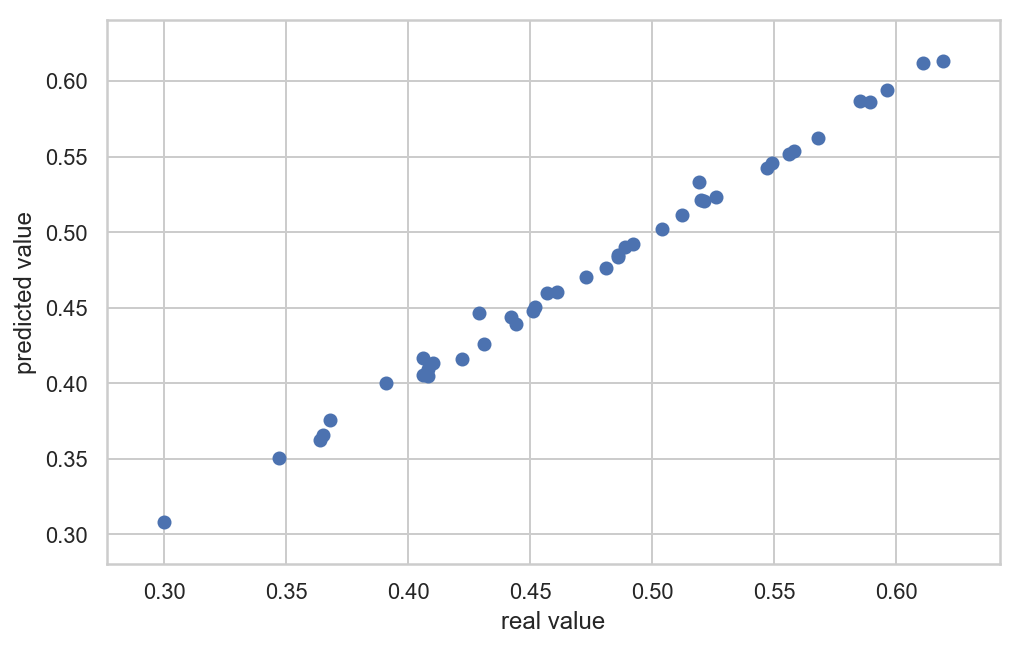

Chi^2       : 57.721
P-value     :  0.000
train R2 = 0.99997788, test R2 = 0.99064025


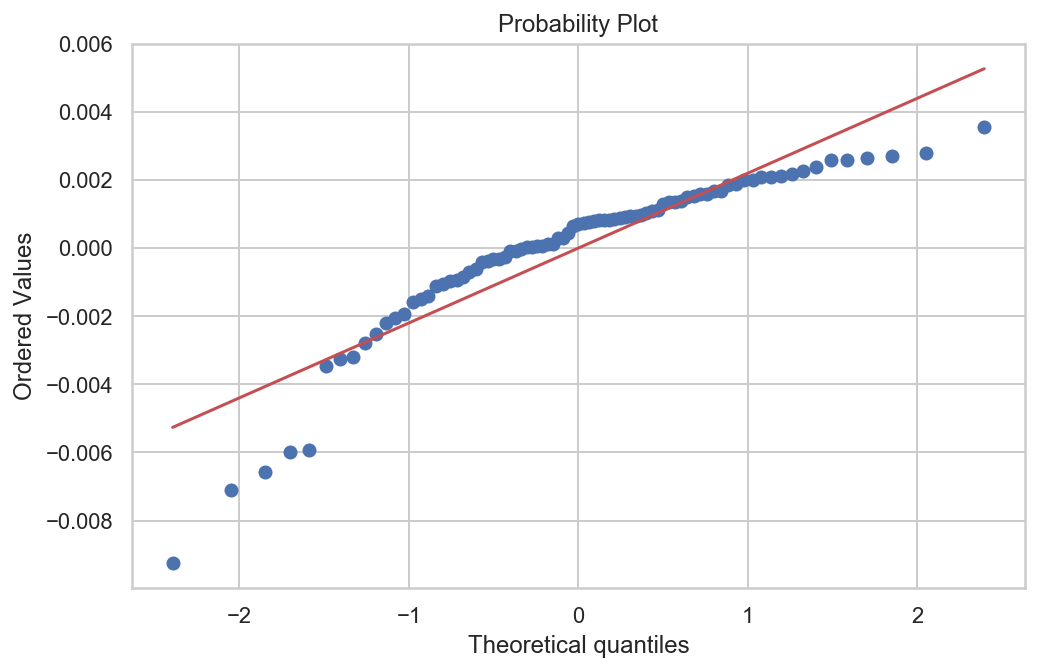

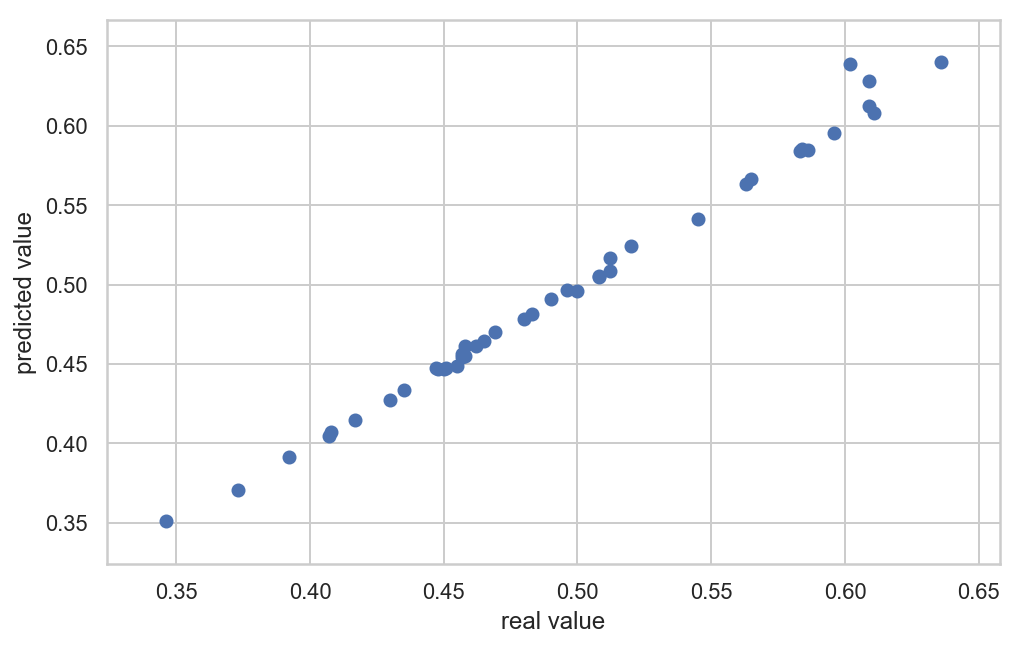

Chi^2       : 37.272
P-value     :  0.000
train R2 = 0.99993617, test R2 = 0.99729660


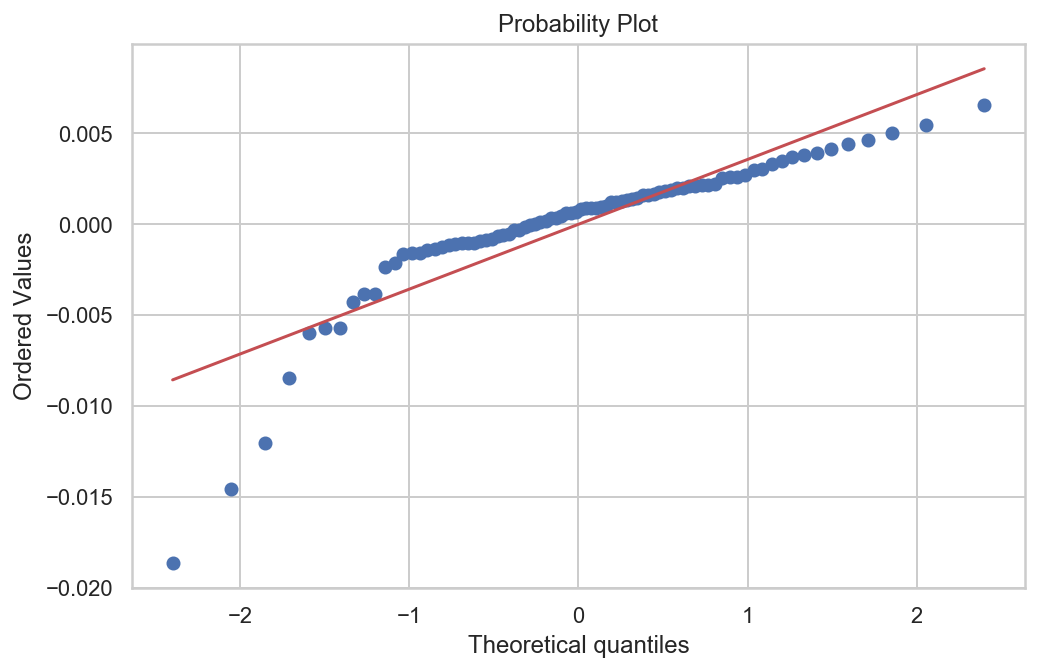

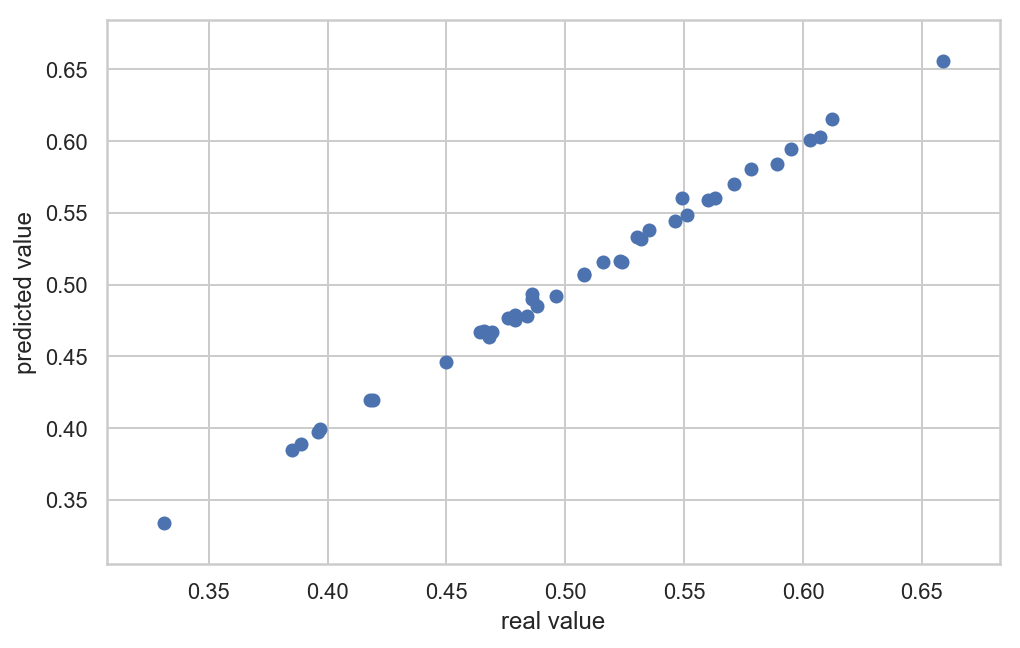

Chi^2       : 58.570
P-value     :  0.000


In [9]:
dfX_all = df[['ERA', 'save', 'hold', 'PW', 'P_hitted', 'SO', 'WHIP', 'CG', 'shutout',
           'QS', 'BV', 'PN', 'P_AVG', 'WP', 'AVG', 'scoring', 'hit', 'double',
           'triple', 'HR', 'RBI', 'SAC', 'SF', 'OPS', 'RISP', 'PA_BA', 'error']]

dfX_all = sm.add_constant(dfX_all)
dfy = df[["win_rate"]]

new_df = pd.concat([dfy, dfX_all], axis=1)

scores = np.zeros(3)
cv = KFold(3, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_df)):
    df_train = df.iloc[idx_train]
    df_test = df.iloc[idx_test]
    
    model = sm.OLS(df_train.win_rate, df_train[['ERA', 'save', 'hold', 'PW', 'P_hitted', 'SO', 
                                            'WHIP', 'CG', 'shutout', 'QS', 'BV', 'PN', 'P_AVG', 
                                            'WP', 'AVG', 'scoring', 'hit', 'double', 'triple', 
                                            'HR', 'RBI', 'SAC', 'SF', 'OPS', 'RISP', 'PA_BA', 'error']])
    result = model.fit()

    pred = result.predict(df_test[['ERA', 'save', 'hold', 'PW', 'P_hitted', 'SO', 
                                    'WHIP', 'CG', 'shutout', 'QS', 'BV', 'PN', 'P_AVG', 
                                    'WP', 'AVG', 'scoring', 'hit', 'double', 'triple', 
                                    'HR', 'RBI', 'SAC', 'SF', 'OPS', 'RISP', 'PA_BA', 'error']])
    
    rss = ((df_test.win_rate - pred) ** 2).sum()
    tss = ((df_test.win_rate - df_test.win_rate.mean()) ** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("train R2 = {:.8f}, test R2 = {:.8f}".format(result.rsquared, rsquared))
    
    plt.figure(figsize=(8, 5))
    sp.stats.probplot(result.resid, plot=plt)
    plt.show()
    
    plt.figure(figsize=(8, 5))
    plt.scatter(df_test.win_rate, pred)
    plt.xlabel('real value')
    plt.ylabel('predicted value')
    plt.show()
    
    test = sm.stats.omni_normtest(result.resid)
    for xi in zip(['Chi^2', 'P-value'], test):
        print("%-12s: %6.3f" % xi)

- 결정계수 퍼포먼스에 가장 영향을 끼치는 피쳐 추출

1) 도메인 지식 상 변수간 상관관계가 강한 데이터 셋이기 때문에 VIF 지수로 다중공선성을 최소화 하여 변수를 추출

수비와 공격 각각의 지표에서 두개이상 지표가 섞일경우 VIF 지수가 매우 높아지는 현상 식별, 최소한의 피쳐선택으로 다중공선성 및 condition number 급증 현상을 줄이고자 하는 의도

2) 수비지표에서는 ERA(팀 방어율)와 save(팀 세이브)가 승률에 강하게 영향을 주는 것으로 확인

3) 공격지표에서는 scoring(팀득점), RBI(팀타점), OPS(팀OPS)가 승률에 강하게 영향을 주는 것으로 확인 

#### ㅇ 결론적으로 모델을 구성하기 위한 피쳐로 수비지표에서는 ERA는 공격지표에서는 OPS를 선택

In [10]:
X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size = 0.2, random_state = 101)

for L in range(1, 3+1):
    for subset in itertools.combinations(dfX.columns[1:], L): # dfX.columns에서 L개를 선택하는 모든 조합
        
        columns = list(subset)
        columns.append('const')
        
        new_x_train = X_train[columns] # X[tuple]은 작동하지 않아서, X[list]형태로 바꿔준 것
        new_x_test = X_test[columns]
        
        model = sm.OLS(y_train,new_x_train).fit()
        pred = model.predict(new_x_test)
        pred = pd.DataFrame(pred, columns=['win_rate'])
        
        rss = ((y_test - pred) ** 2).sum()[0]
        tss = ((y_test - y_test.mean()) ** 2).sum()[0]
        rsquared = 1 - rss / tss
    
        base_accuracy = 0.8
        if rsquared > base_accuracy:
            print(list(subset), '\t', rsquared) 

['ERA', 'scoring'] 	 0.836221079671827
['ERA', 'RBI'] 	 0.8276125405540665
['ERA', 'OPS'] 	 0.8208170219146089
['ERA', 'save', 'scoring'] 	 0.8913522785437897
['ERA', 'save', 'RBI'] 	 0.8905377074886883
['ERA', 'save', 'OPS'] 	 0.8896006074179582
['ERA', 'hold', 'scoring'] 	 0.8359198260523067
['ERA', 'hold', 'RBI'] 	 0.8256593047124634
['ERA', 'hold', 'OPS'] 	 0.8240213448208071
['ERA', 'P_hitted', 'scoring'] 	 0.8497375884000019
['ERA', 'P_hitted', 'RBI'] 	 0.8397440901782567
['ERA', 'P_hitted', 'OPS'] 	 0.8202915169276047
['ERA', 'SO', 'scoring'] 	 0.8391082956798452
['ERA', 'SO', 'RBI'] 	 0.8298688980826551
['ERA', 'SO', 'OPS'] 	 0.8287152946760252
['ERA', 'WHIP', 'scoring'] 	 0.8362333079347508
['ERA', 'WHIP', 'RBI'] 	 0.8274799149192051
['ERA', 'WHIP', 'OPS'] 	 0.8209242294706027
['ERA', 'CG', 'scoring'] 	 0.8207416103212224
['ERA', 'CG', 'RBI'] 	 0.8071967040988538
['ERA', 'CG', 'OPS'] 	 0.8124505390660526
['ERA', 'shutout', 'scoring'] 	 0.8357913623238215
['ERA', 'shutout', 'RB

- correlation heatmap으로 종속변수와 독립변수 간 상관관계 확인

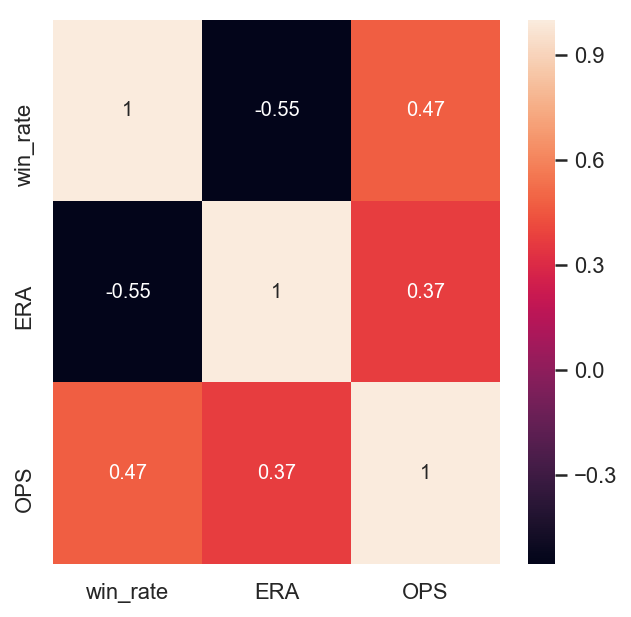

In [12]:
plt.figure(figsize=(5,5))
sns.heatmap(data = df[['win_rate','ERA', 'OPS']].corr(), annot = True)
plt.show()

- 독립변수 간 VIF 지수 점검

VIF 지수 : 특정 독립변수가 다른 독립변수에 얼마나 의존적인지 숫자로 표현한 지수. 통상적으로 10을 기준으로 의존적이다, 의존적이지 않다 판단

VIF 지수가 다소 높게 측정되었으나 예측성능과 condition number에 큰 영향을 주지 않는 것으로 보아 다중공선성이 없는 것으로 판단

In [15]:
df2 = df[['ERA', 'OPS']]

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df2.values, i) for i in range(df2.shape[1])]
vif["features"] = df2.columns
vif.sort_values(["VIF Factor"], ascending=[False])

,VIF Factor,features
0,57.315397,ERA
1,57.315397,OPS


#### STEP 5) 모델링 및 모델평가

1) 모델 구현

In [16]:
X = dfX[['ERA', 'OPS','const']]
y = dfy[["win_rate"]]

model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               win_rate   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     317.3
Date:                Fri, 14 Jun 2019   Prob (F-statistic):           4.51e-49
Time:                        14:05:35   Log-Likelihood:                 262.19
No. Observations:                 125   AIC:                            -518.4
Df Residuals:                     122   BIC:                            -509.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ERA           -0.0960      0.004    -21.563      0.000      -0.105      -0.087
OPS            1.2447      0.062     20.081      0.000       1.122       1.367
const         -0.0133      0.044     -0.305      0.761      -0.100       0.073
==============================================================================
Omnibus:                        0.713   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.700   Jarque-Bera (JB):                0.826
Skew:                           0.100   Prob(JB):                        0.662
Kurtosis:                       2.656   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

2) 부분회귀로 각각의 독립변수로 종속변수에 대해서 실질적인 회귀성능 점검

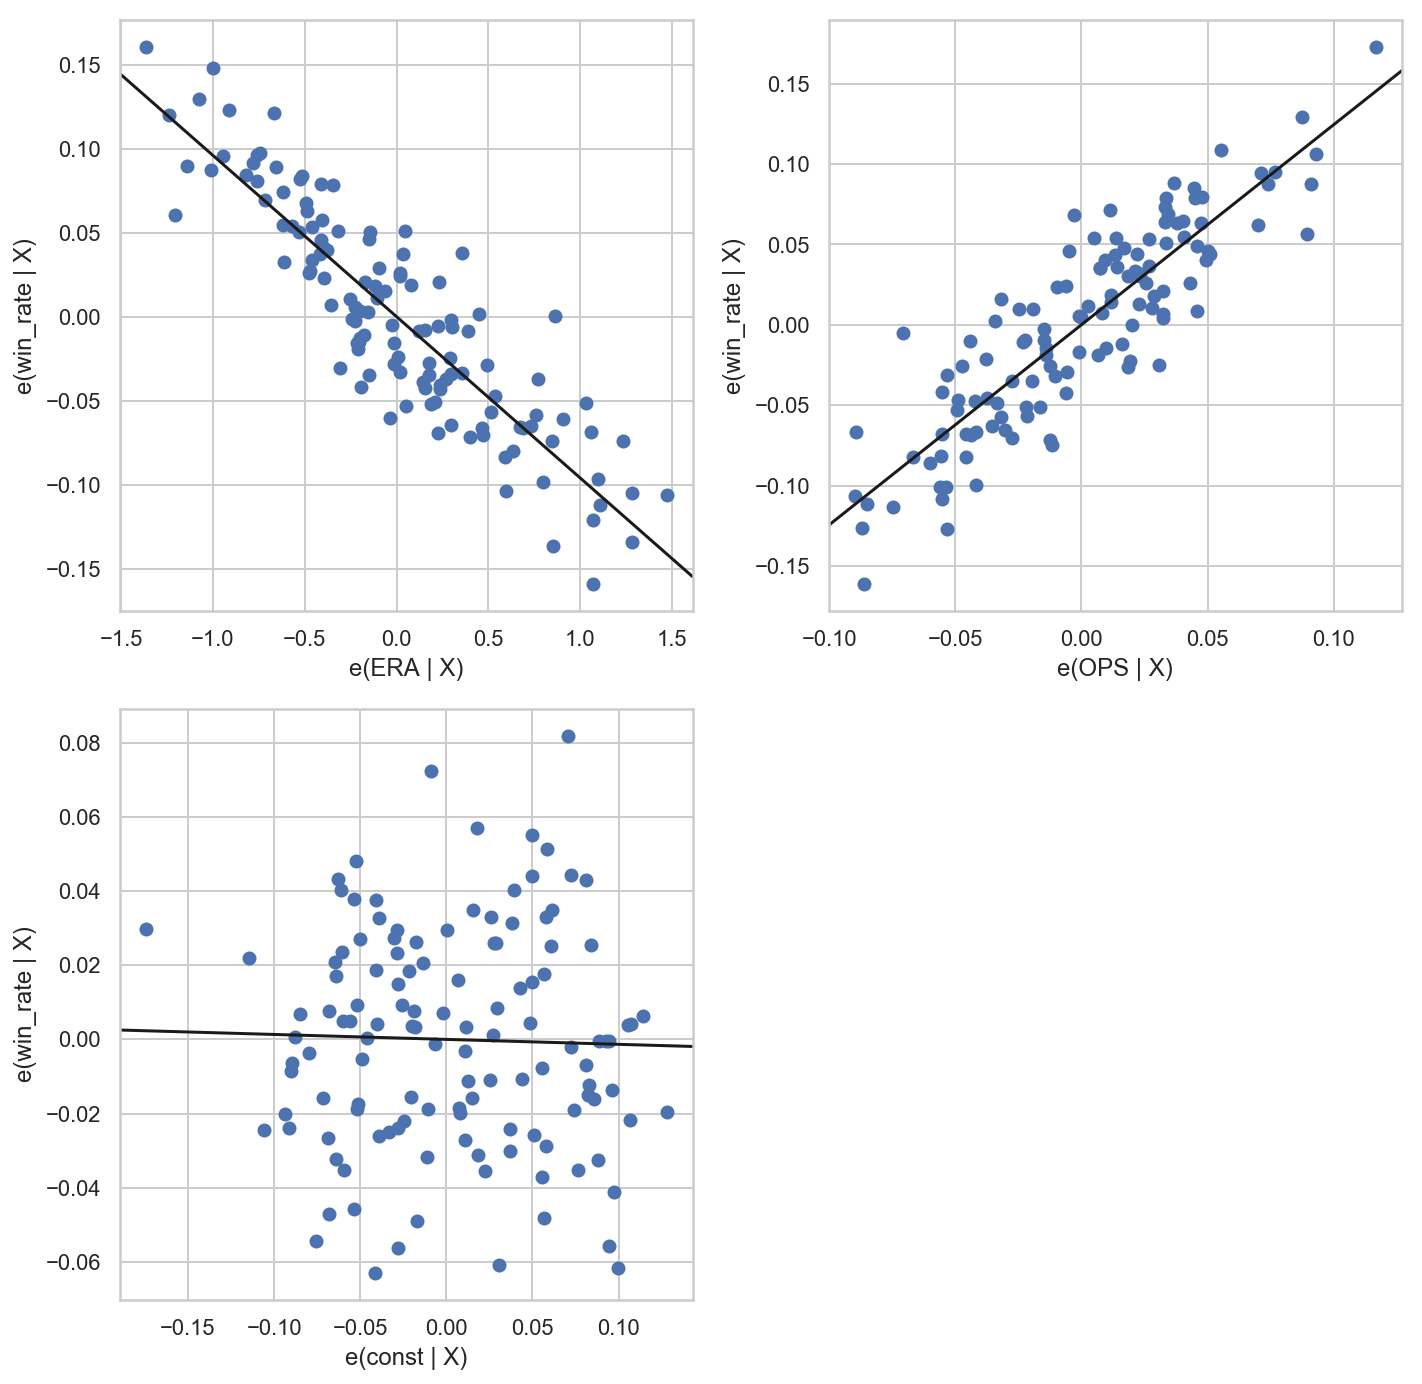

In [17]:
fig = plt.figure(figsize=(10, 10))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

3) 실제 데이터와 모델 예측값 비교

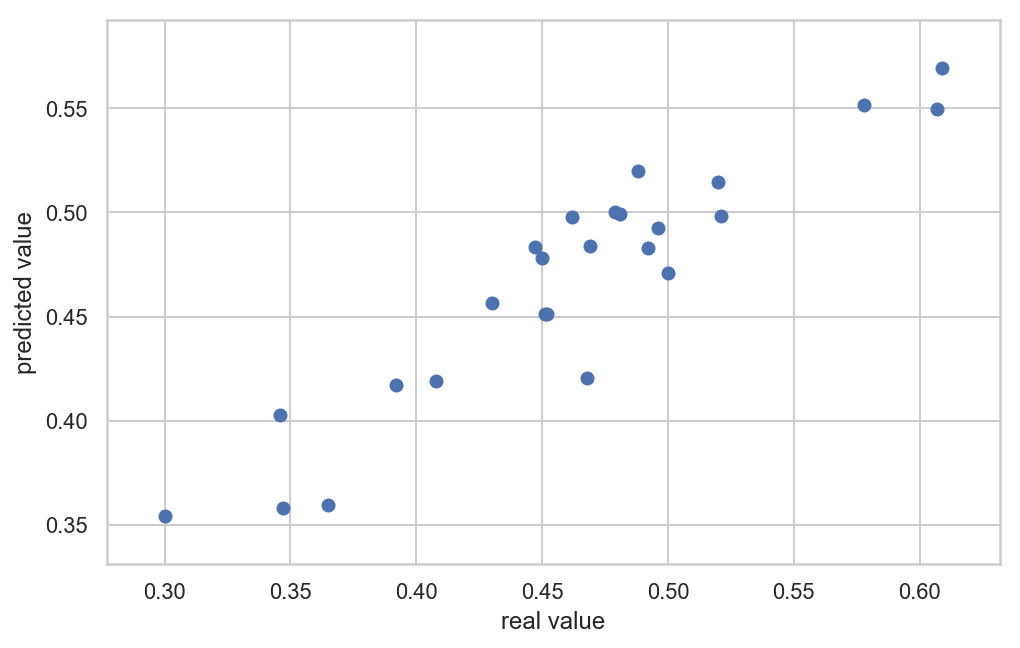

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

plt.figure(figsize=(8, 5))
plt.scatter(y_test, result.predict(X_test))
plt.xlabel('real value')
plt.ylabel('predicted value')
plt.show()

- 2019 시즌데이터 적용

In [19]:
kiwoom = result.predict([4.08,0.757,1])
doosan = result.predict([3.31,0.757,1])
sk = result.predict([3.53,0.716,1])
KIA = result.predict([4.85,0.724,1])
NC = result.predict([4.08,0.781,1])
SAMSUNG = result.predict([4.24,0.736,1])

print("순서       : 키움, 두산, SK, 기아 NC 삼성")
print("모델예측치 :", round(kiwoom[0],3), round(doosan[0],3), round(sk[0],3), round(KIA[0],3), round(NC[0],3), round(SAMSUNG[0],3))
print("실제       : 0.543 0.623 0.657 0.418 0.537 0.433")

순서       : 키움, 두산, SK, 기아 NC 삼성
모델예측치 : 0.537 0.611 0.539 0.422 0.567 0.496
실제       : 0.543 0.623 0.657 0.418 0.537 0.433


4) 잔차정규성 검정

- QQ Plot 드로잉 시 잔차정규성 가정을 만족하는 빨간색 대각선과 유사


- 카이제곱 검정 시 p-value 70%로 잔차정규성 통과하는 것으로 판단

=> 잔차정규성을 충족하여 확률론적 선형회귀모형의 가정을 올바르게 충족한다고 판단

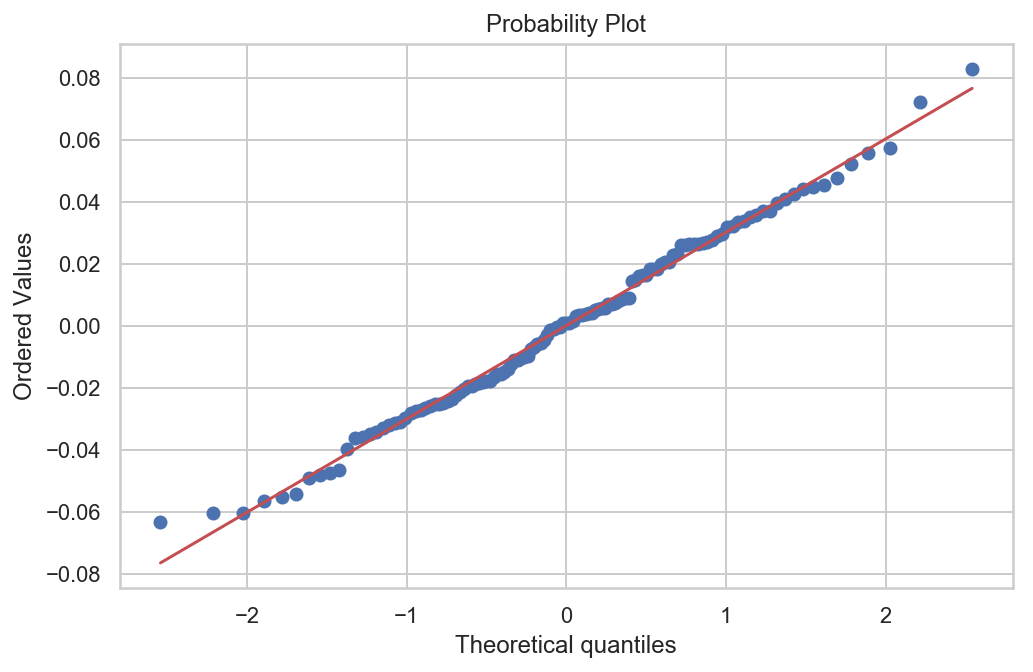

In [20]:
plt.figure(figsize=(8, 5))
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [21]:
test = sm.stats.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  0.713
P-value     :  0.700


5) Kfold 교차검증

In [22]:
df = pd.concat([X,y],axis=1)

scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df)):
    df_train = df.iloc[idx_train]
    df_test = df.iloc[idx_test]
    
    model = sm.OLS(df_train.win_rate, df_train[['OPS', 'ERA','const']])
    result = model.fit()

    pred = result.predict(df_test[['OPS', 'ERA','const']])
    rss = ((df_test.win_rate - pred) ** 2).sum()
    tss = ((df_test.win_rate - df_test.win_rate.mean()) ** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("train R2 = {:.8f}, test R2 = {:.8f}".format(result.rsquared, rsquared))
    
print("test 퍼포먼스 평균 : ", scores.mean())

train R2 = 0.80075343, test R2 = 0.92721464
train R2 = 0.83360177, test R2 = 0.86415957
train R2 = 0.84976854, test R2 = 0.77054431
train R2 = 0.84717910, test R2 = 0.79771835
train R2 = 0.86177633, test R2 = 0.70430950
test 퍼포먼스 평균 :  0.8127892746444972
